# ML Classification of FRBs using Supervised Methods
### Features :-

THIS NOTEBOOK DEMONSTRATE THE PROCESS OF DATA ANALYSIS OF THE CHIME(Canadian Hydrogen Intensity Mapping Experiment) FRBs 

In [1]:
# importing the  necessary libraries 
import pandas as pd 
import numpy as np

In [2]:
# reading the csv file
df = pd.read_csv("../datasets/chimefrbcat1.csv")

In [3]:
# cleaning the cols with '<' ,  '' , these characters

df['scat_time']=df['scat_time'].str.replace(r'<','')
df['scat_time']=df['scat_time'].astype(float)
df['width_fitb']=df['width_fitb'].str.replace(r'<','')
df['width_fitb']=df['width_fitb'].astype(float)

In [4]:
# creating one col repeating in df which is equal to 1 if repeating 0 otherwise  

df['repeating'] = np.where(df['repeater_name'] == "-9999", 0, 1) 

In [5]:
# drop unecessary columns from the df 

df=df.drop(columns=['ra_notes','dec_notes','exp_up_notes','exp_low_notes','flux_notes','fluence_notes',
                    'ra_err','dec_err','exp_up_err','exp_low_err','dm_fitb_err','scat_time_err','flux_err','fluence_err','mjd_400','mjd_400_err','mjd_inf','mjd_inf_err','width_fitb_err','sp_idx_err','sp_run_err'])
print(len(df.columns))
df.head()

35


,tns_name,previous_name,repeater_name,ra,dec,gl,gb,exp_up,exp_low,bonsai_snr,...,sp_idx,sp_run,high_freq,low_freq,peak_freq,chi_sq,dof,flag_frac,excluded_flag,repeating
0,FRB20180725A,180725.J0613+67,-9999,93.42,67.07,147.29,21.29,30.0,-9999.0,19.2,...,38.20,-45.80,760.1,485.3,607.4,371857.954,371481,0.403,1,0
1,FRB20180727A,180727.J1311+26,-9999,197.72,26.42,24.76,85.60,10.4,-9999.0,10.4,...,3.80,-9.20,800.2,400.2,493.3,382969.318,381818,0.387,1,0
2,FRB20180729A,180729.J1316+55,-9999,199.40,55.58,115.26,61.16,21.0,-9999.0,32.0,...,16.46,-30.21,692.7,400.2,525.6,264732.041,186953,0.399,1,0
3,FRB20180729B,180729.J0558+56,-9999,89.93,56.50,156.90,15.68,21.0,-9999.0,12.4,...,14.50,-14.60,800.2,441.8,657.5,425139.488,421337,0.323,1,0
4,FRB20180730A,180730.J0353+87,-9999,57.39,87.19,125.11,25.11,270.0,214.0,69.5,...,4.27,-11.31,759.2,400.2,483.5,429165.844,417689,0.329,1,0


## Calculation of Secondary Features 
In this section we will calculate the secondary features which are derived using the primary features 

### Redshift

In [6]:
# defining the constants we will use later 
# for units we will use astropy libraries 

import astropy.units as u
# Parameters

H=67.4  #67.3 #km/s/Mpc
h=H/100
h2=h*h
O_b=0.0224/h2  #0.0486
O_m=0.315  #matter
O_k=0
O_L=1-O_m-O_k  #dark energy

c=299792458 #m/s
pc_m=3.085677581491367e+16
cm=100
km=1000
M=1e6
m_p=1.67262192e-27  #kg
G=6.67430e-11  #m^3/kg/s^2

### Formulas used :-

$DM-DM_{MW}=30+DM_{IGM}+\frac{70}{1+z}$ 

defining alpha as : $ \Omega_b\frac{3H_0 c}{8\pi G m_p}\frac{7}{8} $

In [7]:
# defining alpha with proper unit conversions
alpha=3*7*H*c*O_b/8/8/np.pi/G/m_p*km/M/pc_m/cm/cm/cm/pc_m

In [8]:
from scipy import integrate

def f_IGM(z):
    return 0.83

def I_IGM(z,m=O_m,la=O_L):
    return (1.+z)*f_IGM(z)/np.sqrt(m*(1.+z)**3+la)

def f_DM(z,a=alpha):
    Int=integrate.quad(I_IGM,0,z)[0]
    return 30.0+a*Int+70.0/(1.+z)

In [9]:
from scipy.optimize import fsolve
def f_z(DM_MW,n=8):
    return fsolve(lambda z:f_DM(z)-DM_MW,0)[0]

In [10]:
# to avoid zero or negative value we r setting minimum redshift as 0.00225
z_min=H*10/c*1000
DM_MWs=df['dm_exc_ne2001'].values
redshift=np.zeros(len(DM_MWs))
for i,DM_MW in enumerate(DM_MWs):
    redshift[i]=f_z(DM_MW)
    if(redshift[i]<=z_min):
        #print(i)
        redshift[i]=z_min
df['redshift']=redshift

## Rest-Frame Frequency width

formula : ∆ν = (νmax − νmin)(1 + z)

In [11]:
df['fre_width']=(df['high_freq']-df['low_freq'])*(1+df['redshift'])
df['fre_width_ob']=(df['high_freq']-df['low_freq'])

## Rest Frame width(s)

formula : $\frac{Width\,of\,sub-burst\,using\,fitburst}{1+z}$

In [12]:
rest_width=df['width_fitb'].values/(1+redshift)
df['rest_width']=rest_width

In [13]:
# astropy.cosmos distance

from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(H0=H*u.km/u.s/u.Mpc,Om0=O_m)
d_L_cos=cosmo.luminosity_distance(df['redshift'])#MPc

## Burst Energy

formula : $E=\frac{4\pi d_L^2}{1+z}F_\nu \nu_c$

In [14]:
d_L=d_L_cos #cos with units *u.Mpc
energy=4*np.pi*df['fluence']*u.Jy*u.ms*df['peak_freq']*u.MHz
energy=energy*d_L*d_L/(1+redshift)
df['energy'] = energy * 1e29

## Brightness Temperature 

formula : $T_b=\frac{S_{\nu,p}d_L^2}{2\pi k_B(\nu \Delta t)^2}/(1+z)$ , $d_A=\frac{d_L}{(1+z)^2}$

In [15]:
import astropy.constants as c
d_L=d_L_cos
nu=df['peak_freq']*u.MHz
dt=df['bc_width']*u.s
TB=d_L**2*df['flux']*u.Jy/(1+redshift)/((nu*dt)**2)
df['bright_temp'] = (TB/(2*np.pi*c.k_B)) * 1e1
df.head()

,tns_name,previous_name,repeater_name,ra,dec,gl,gb,exp_up,exp_low,bonsai_snr,...,dof,flag_frac,excluded_flag,repeating,redshift,fre_width,fre_width_ob,rest_width,energy,bright_temp
0,FRB20180725A,180725.J0613+67,-9999,93.42,67.07,147.29,21.29,30.0,-9999.0,19.2,...,371481,0.403,1,0,0.640740,450.875425,274.8,0.000180,2.970091e+40,5.792865e+29
1,FRB20180727A,180727.J1311+26,-9999,197.72,26.42,24.76,85.60,10.4,-9999.0,10.4,...,381818,0.387,1,0,0.614818,645.927163,400.0,0.000861,1.249365e+40,2.754578e+29
2,FRB20180729A,180729.J1316+55,-9999,199.40,55.58,115.26,61.16,21.0,-9999.0,32.0,...,186953,0.399,1,0,0.002248,293.157605,292.5,0.000100,1.124159e+36,5.089481e+26
3,FRB20180729B,180729.J0558+56,-9999,89.93,56.50,156.90,15.68,21.0,-9999.0,12.4,...,421337,0.323,1,0,0.157566,414.871625,358.4,0.000271,5.215744e+38,3.325295e+28
4,FRB20180730A,180730.J0353+87,-9999,57.39,87.19,125.11,25.11,270.0,214.0,69.5,...,417689,0.329,1,0,0.802405,647.063272,359.0,0.000260,2.452905e+41,1.583900e+30


In [16]:
# verifying the no. of bursts

print(f"Total frbs: {len(df['tns_name'])}, Non-repeating: {np.sum(df['repeating']==0)}, Repeating: {np.sum(df['repeating']==1)}")
df=df.drop(df[df.energy==0].index)
df.reset_index(drop=True,inplace=True)
print(f"Total frbs: {len(df['tns_name'])}, Non-repeating: {np.sum(df['repeating']==0)}, Repeating: {np.sum(df['repeating']==1)}")

Total frbs: 600, Non-repeating: 506, Repeating: 94
Total frbs: 594, Non-repeating: 500, Repeating: 94


### log10 columns for Secondary features

In [17]:
col1=df.columns
col=['repeater_name', 'fre_width', 'redshift', 'rest_width','energy','bright_temp']

In [18]:
logcol=['repeater_name']
for i in range(1,len(col)):
    logcol.append('log_'+col[i])
print(logcol)
logf=df[col]
logf.columns=logcol
for c in logcol[1:]:
    #print(c)
    for i in range(len(logf['log_redshift'])):
        if(logf.loc[i,c]==0):
            logf.loc[i,c]=0.01
        #print([c,i,logf.loc[i,c]])
        logf.loc[i,c]=np.log10(logf.loc[i,c])
logf.head()

['repeater_name', 'log_fre_width', 'log_redshift', 'log_rest_width', 'log_energy', 'log_bright_temp']


,repeater_name,log_fre_width,log_redshift,log_rest_width,log_energy,log_bright_temp
0,-9999,2.654057,-0.193318,-3.743748,40.472770,29.762893
1,-9999,2.810184,-0.211253,-3.065109,40.096689,29.440055
2,-9999,2.467101,-2.648161,-4.000975,36.050828,26.706673
3,-9999,2.617914,-0.802538,-3.566616,38.717316,28.521830
4,-9999,2.810947,-0.095607,-3.585606,41.389681,30.199728


In [19]:
# Save

df=df[col1]
df=pd.concat([df,logf.iloc[:,1:]],axis=1)
df.drop(columns=['gl','exp_up','exp_low','bonsai_snr','snr_fitb','flag_frac', 'excluded_flag'],inplace=True)
df.head()

,tns_name,previous_name,repeater_name,ra,dec,gb,bonsai_dm,low_ft_68,up_ft_68,low_ft_95,...,fre_width,fre_width_ob,rest_width,energy,bright_temp,log_fre_width,log_redshift,log_rest_width,log_energy,log_bright_temp
0,FRB20180725A,180725.J0613+67,-9999,93.42,67.07,21.29,716.6,0.0,2.7,0.0,...,450.875425,274.8,0.000180,2.970091e+40,5.792865e+29,2.654057,-0.193318,-3.743748,40.472770,29.762893
1,FRB20180727A,180727.J1311+26,-9999,197.72,26.42,85.60,642.1,0.0,1.9,0.0,...,645.927163,400.0,0.000861,1.249365e+40,2.754578e+29,2.810184,-0.211253,-3.065109,40.096689,29.440055
2,FRB20180729A,180729.J1316+55,-9999,199.40,55.58,61.16,108.4,0.0,4.6,0.0,...,293.157605,292.5,0.000100,1.124159e+36,5.089481e+26,2.467101,-2.648161,-4.000975,36.050828,26.706673
3,FRB20180729B,180729.J0558+56,-9999,89.93,56.50,15.68,318.6,0.0,0.9,0.0,...,414.871625,358.4,0.000271,5.215744e+38,3.325295e+28,2.617914,-0.802538,-3.566616,38.717316,28.521830
4,FRB20180730A,180730.J0353+87,-9999,57.39,87.19,25.11,849.2,3.3,2.3,6.1,...,647.063272,359.0,0.000260,2.452905e+41,1.583900e+30,2.810947,-0.095607,-3.585606,41.389681,30.199728


In [22]:
# changing into ms
df['bc_width'] *= 1e3
# df['rest_width'] *= 1e3

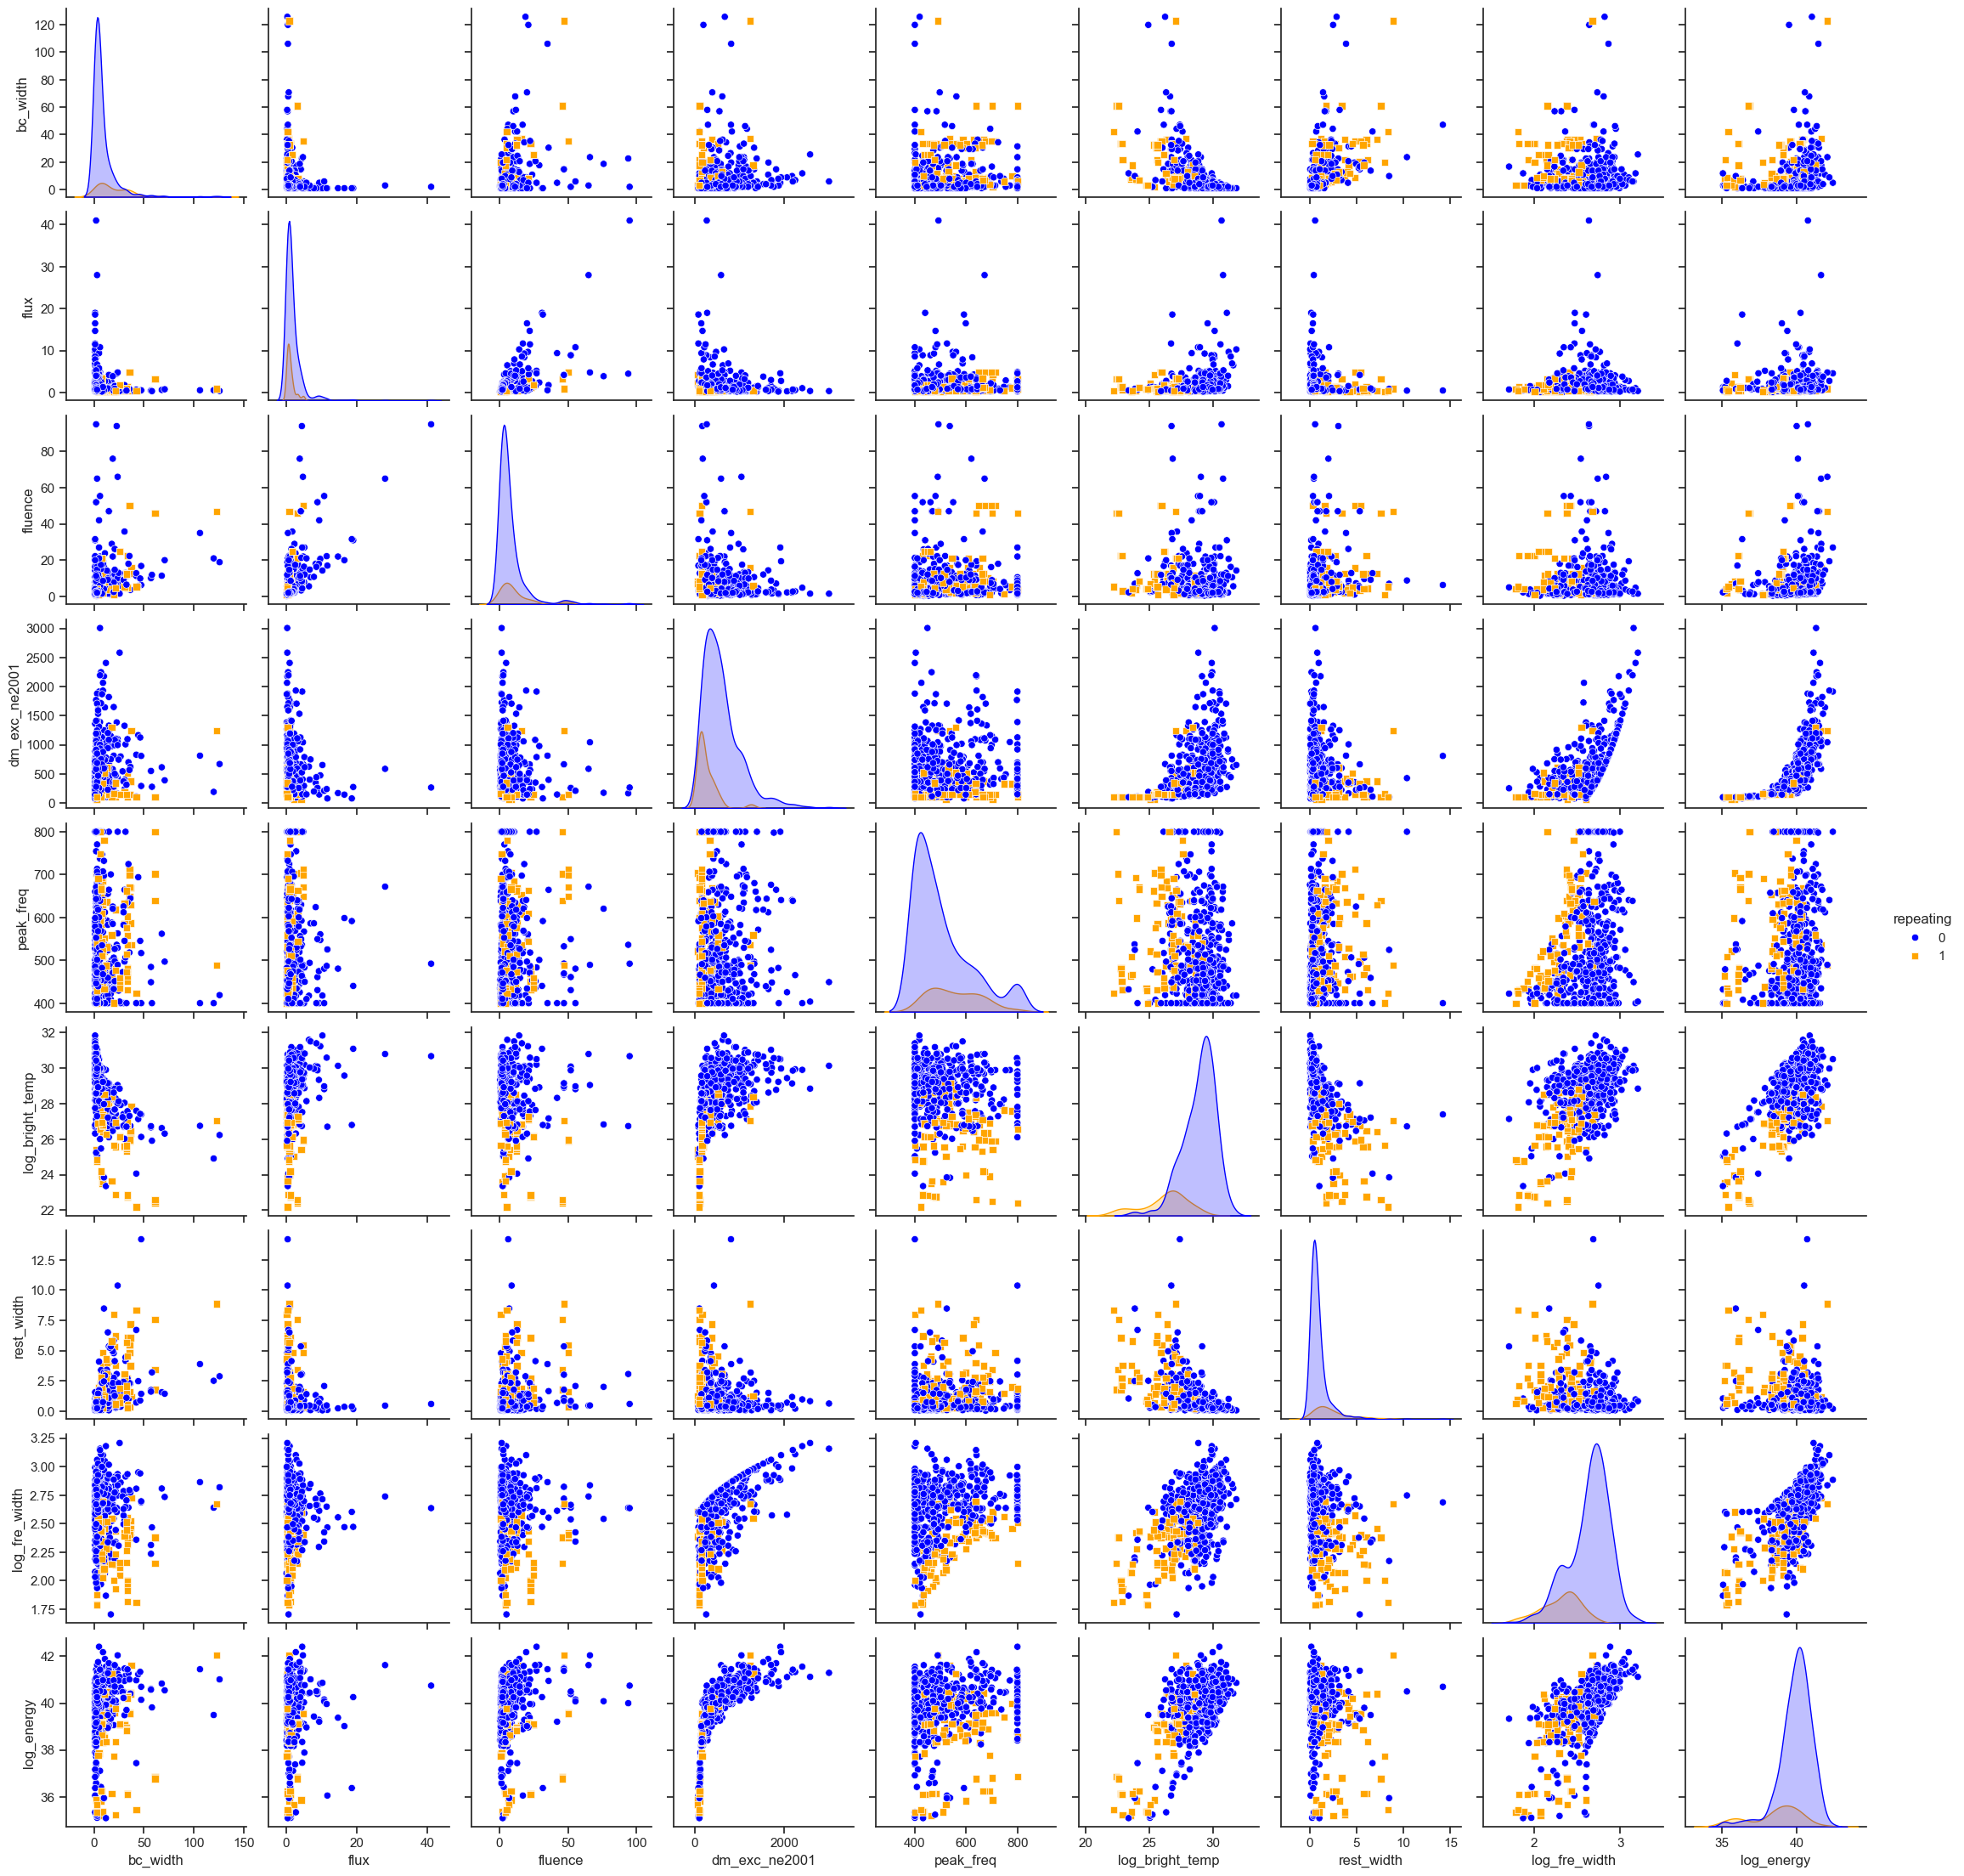

In [23]:
# plotting the graph b/w the features 

import seaborn as sns
sns.set(style="ticks")
sns.pairplot(df[['bc_width','flux','fluence', 'dm_exc_ne2001','peak_freq','log_bright_temp','rest_width','log_fre_width','log_energy','repeating']], hue='repeating', diag_kind='kde', markers=['o', 's'], palette={0: 'blue', 1: 'orange'})

In [24]:
# save the preprocessed data into a csv file
df.to_csv(r"cul_cat1.csv")